In [1]:
import data_reader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
path2submitsA  = 'iui20_ideaSubmits.csv'
path2requestsA = 'iui20_inspirationRequests.csv'

path2submitsB  = 'iui20_ideaSubmitsPart2.csv'
path2requestsB = 'iui20_inspirationRequestsPart2.csv'

seconds_per_bucket = 15
train_percentage = 0.1

In [3]:
#load data as sessions
sessionsA = data_reader.load_data_as_sessions_dict(path2submitsA, path2requestsA, seconds_per_bucket)
sessionsB = data_reader.load_data_as_sessions_dict(path2submitsB, path2requestsB, seconds_per_bucket)
# calculate avoiders and seekers
sessionsA = data_reader.add_avoiders_undetermined_and_seekers(sessionsA)
sessionsB = data_reader.add_avoiders_undetermined_and_seekers(sessionsB)
# create train and test set of worker ids
# NOT needed here because the entire sessionA is trainset and the entire sessionB is the testset
#train_worker_ids, test_worker_ids = data_reader.split_worker_ids_into_train_test(sessionsA, train_percentage=train_percentage)
#train_worker_ids, test_worker_ids = data_reader.split_worker_ids_into_train_test(sessionsB, train_percentage=train_percentage)

[array([[13.,  1.],
       [74., 12.]]),
 array([[13.,  1.],
       [38., 47.]]),
 array([[13.,  1.],
       [21., 65.]]),
 array([[15.,  0.],
       [29., 56.]]),
 array([[13.,  1.],
       [29., 56.]]),
 array([[13.,  1.],
       [21., 65.]]),
 array([[13.,  1.],
       [21., 65.]]),
 array([[13.,  1.],
       [15., 71.]]),
 array([[12.,  2.],
       [15., 71.]]),
 array([[12.,  2.],
       [18., 68.]])]


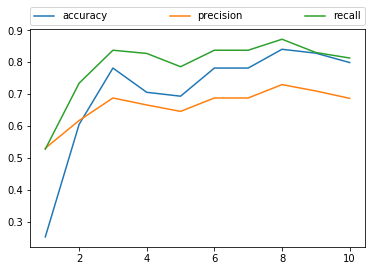

In [4]:
# iterate through different numbers of buckets
# train a classifier for each different numbers of buckets
# test on test examples
# get roc curve
conf_matrices    = []
accuracies       = []
precisions_micro = []
recalls_micro    = []
max_number_of_buckets = 40
for nr_of_buckets in range(1, max_number_of_buckets, int(60/seconds_per_bucket)):
    train_worker_ids = list(sessionsA.keys())
    x_tr, y_tr, _, _ = data_reader.create_train_test_dataset(nr_of_buckets, train_worker_ids, [], sessionsA, train_percentage)
    test_worker_ids  = list(sessionsB.keys())
    _, _, x_te, y_te = data_reader.create_train_test_dataset(nr_of_buckets, [], test_worker_ids, sessionsB, train_percentage)
    #clf = DecisionTreeClassifier()
    clf = RandomForestClassifier(200, max_depth=100, class_weight='balanced')
    clf.fit(x_tr, y_tr)
    y_pre = clf.predict(x_te)
    
    sample_weight = 1.0 * np.bincount(y_te) / len(y_te)
    sample_weight = [sample_weight[y_te[i]] for i in range(len(y_te))]
    
    conf_matrices   .append(confusion_matrix(y_te, y_pre, sample_weight=sample_weight))
    accuracies      .append(accuracy_score  (y_te, y_pre, sample_weight=sample_weight))
    precisions_micro.append(precision_score (y_te, y_pre, average='macro', sample_weight=sample_weight))
    recalls_micro   .append(recall_score    (y_te, y_pre, average='macro', sample_weight=sample_weight))

# [[tn, fp, fn, tp], ...]
#conf_matrices = np.array([conf_m.ravel() for conf_m in conf_matrices])

#pprint(precisions_micro)
pprint([(100*(conf/np.sum(conf))).round() for conf in conf_matrices])

#plt.xticks(range(1, max_number_of_buckets))
steps = int(max_number_of_buckets / int(60/seconds_per_bucket))
plt.plot(range(1, steps+1), accuracies,       label='accuracy')
plt.plot(range(1, steps+1), precisions_micro, label='precision')
plt.plot(range(1, steps+1), recalls_micro,    label='recall')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.show()

/home/bobby/Env/tensorflow/lib/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


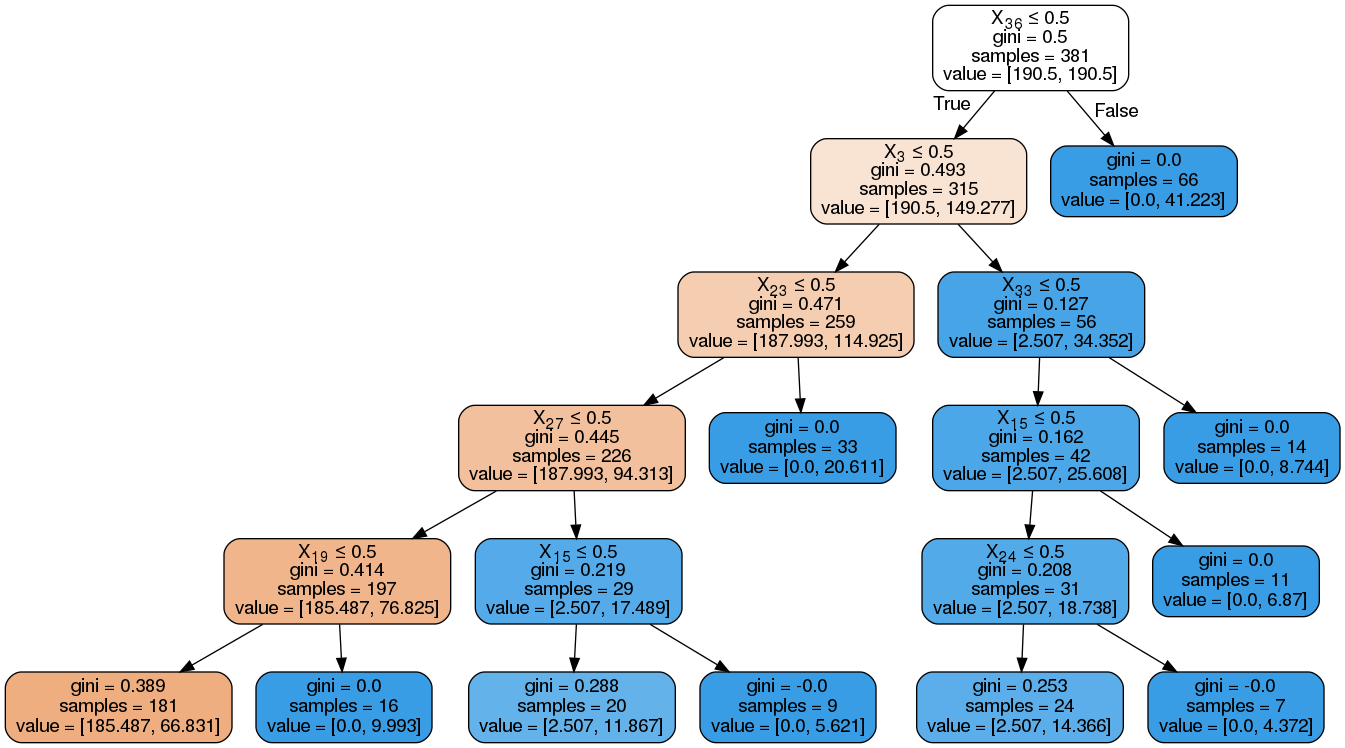

In [10]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

train_percentage = 1.0

train_worker_ids = list(sessionsA.keys())
x_tr, y_tr, _, _ = data_reader.create_train_test_dataset(int(max_number_of_buckets), train_worker_ids, [], sessionsA, train_percentage)
test_worker_ids  = list(sessionsB.keys())
_, _, x_te, y_te = data_reader.create_train_test_dataset(int(max_number_of_buckets), [], test_worker_ids, sessionsB, train_percentage)

clf = DecisionTreeClassifier(max_depth=5, min_impurity_split=0.1, class_weight='balanced')
clf.fit(x_tr, y_tr)
    
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())